# Beijing Air Quality Forecasting Starter Notebook


In [175]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Input
from tensorflow.keras.optimizers import Adam, RMSprop, SGD,Nadam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [176]:
# Kaggle API setup
os.makedirs('/root/.kaggle', exist_ok=True)
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump({"username":"kylapurity","key":"fe7c2eb56dfe10bb08910d741716fb6c"}, f)
!chmod 600 /root/.kaggle/kaggle.json

# Install and upgrade Kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

# Download competition data
!kaggle competitions download -c assignment-1-time-series-forecasting-may-2025
!mkdir -p "/content/data"
!unzip -oq "assignment-1-time-series-forecasting-may-2025.zip" -d "/content/data"

  Using cached kaggle-1.5.8-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.8
    Uninstalling kaggle-1.5.8:
      Successfully uninstalled kaggle-1.5.8
mkdir: cannot create directory ‘/root/.kaggle’: File exists
assignment-1-time-series-forecasting-may-2025.zip: Skipping, found more recently modified local copy (use --force to force download)


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.


In [177]:
# Load the data
df_train_data = pd.read_csv("data/train.csv")
print("Training data shape:", df_train_data.shape)
df_train_data.head()

Training data shape: (30676, 12)


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [178]:
df_test_data = pd.read_csv("data/test.csv")
print("Test data shape:", df_test_data.shape)
df_test_data.head()

Test data shape: (13148, 11)


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv
0,30677,1.190496,0.701029,-2.186052,-0.003982,-0.069353,-0.137667,2013-07-02 04:00:00,1.448138,-0.732019,-0.522096
1,30678,1.121211,0.619051,-2.186052,0.031811,-0.069353,-0.137667,2013-07-02 05:00:00,1.448138,-0.732019,-0.522096
2,30679,1.190496,0.783006,-2.186052,0.094398,-0.069353,-0.137667,2013-07-02 06:00:00,1.448138,-0.732019,-0.522096
3,30680,1.190496,0.946961,-2.088668,0.174782,-0.069353,-0.137667,2013-07-02 07:00:00,1.448138,-0.732019,-0.522096
4,30681,1.190496,1.192893,-1.991283,0.210575,-0.069353,-0.137667,2013-07-02 08:00:00,1.448138,-0.732019,-0.522096


In [179]:
df_train_data.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [180]:
#Ensure 'datetime' column is in datetime format
df_train_data['datetime'] = pd.to_datetime(df_train_data['datetime'])

df_test_data['datetime'] = pd.to_datetime(df_test_data['datetime'])

# Set the 'datetime' column as the index for better time-series handling
df_train_data.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
df_test_data.set_index('datetime', inplace=True)

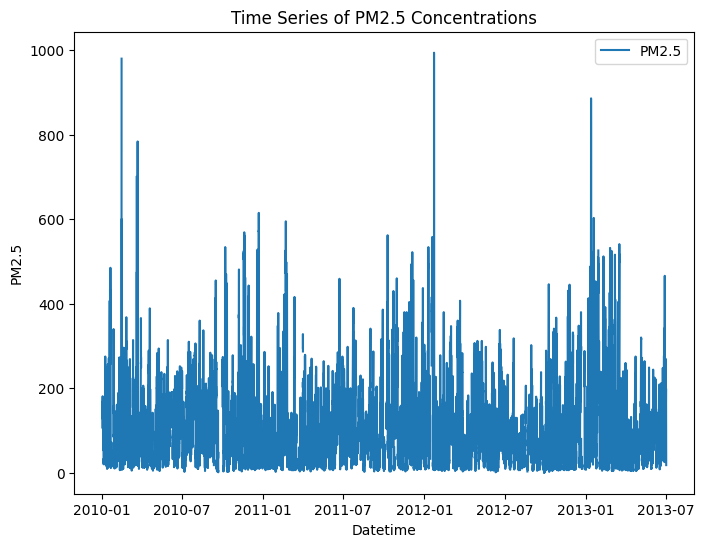

In [181]:
# Visualization: Time series trend for PM2.5
plt.figure(figsize=(8, 6))
# Plot using the DataFrame's index for datetime and access 'pm2.5' from df_train
plt.plot(df_train_data.index, df_train_data['pm2.5'], label='PM2.5')
plt.title('Time Series of PM2.5 Concentrations')
plt.xlabel('Datetime')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

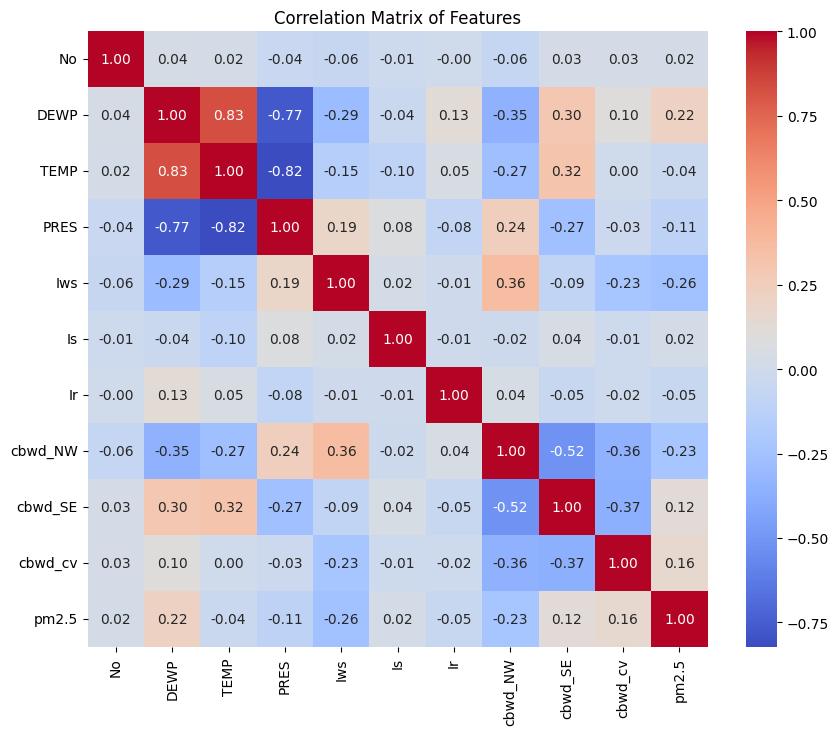

In [182]:
plt.figure(figsize=(10, 8))
# Exclude non-numeric columns before calculating correlations
correlation_matrix = df_train_data.select_dtypes(include=['number']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

# Handle missing values


- Checking the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean and Interpolation. You can experiment with other strategies.

In [183]:
# Checking for missing values
print("\nMissing values in training data:")
print(df_train_data.isnull().sum())


Missing values in training data:
No            0
DEWP          0
TEMP          0
PRES          0
Iws           0
Is            0
Ir            0
cbwd_NW       0
cbwd_SE       0
cbwd_cv       0
pm2.5      1921
dtype: int64


In [184]:
df_train_data.fillna(df_train_data.mean(), inplace=True)
df_test_data.fillna(df_test_data.mean(), inplace=True)

In [185]:
# check if the missining values are fixed
df_train_data.isnull().sum()

,0
No,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
cbwd_NW,0
cbwd_SE,0
cbwd_cv,0


# Feature Engineering

In [186]:
# Get new featurs from the index
for df in [df_train_data, df_test_data]:
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['weekday'] = df.index.weekday
    df['season'] = (df.index.month % 12 + 3) // 3

# Neural networks struggle with cyclical features like hour/month,
# cyclical encoding as sine/cosine is crucial for them to understand cycles, that hour 23 is close to hour 0
for df in [df_train_data, df_test_data]:
    # Hour cyclical encoding (24-hour cycle)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    # Month cyclical encoding (12-month cycle)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Day of week cyclical encoding (7-day cycle)
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)

    # Day of month cyclical encoding (approximate 30-day cycle)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 30)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 30)

In [187]:
df_train_data

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,...,weekday,season,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,day_sin,day_cos
datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,...,4,1,0.000000,1.000000,0.5,0.866025,-0.433884,-0.900969,0.207912,0.978148
2010-01-01 01:00:00,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,...,4,1,0.258819,0.965926,0.5,0.866025,-0.433884,-0.900969,0.207912,0.978148
2010-01-01 02:00:00,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,...,4,1,0.500000,0.866025,0.5,0.866025,-0.433884,-0.900969,0.207912,0.978148
2010-01-01 03:00:00,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,...,4,1,0.707107,0.707107,0.5,0.866025,-0.433884,-0.900969,0.207912,0.978148
2010-01-01 04:00:00,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,...,4,1,0.866025,0.500000,0.5,0.866025,-0.433884,-0.900969,0.207912,0.978148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-07-01 23:00:00,30672,1.467633,0.946961,-2.088668,-0.415099,-0.069353,2.687490,-0.690542,-0.732019,-0.522096,...,0,3,-0.258819,0.965926,-0.5,-0.866025,0.000000,1.000000,0.207912,0.978148
2013-07-02 00:00:00,30673,1.329064,0.864984,-2.186052,-0.379306,-0.069353,3.393779,1.448138,-0.732019,-0.522096,...,1,3,0.000000,1.000000,-0.5,-0.866025,0.781831,0.623490,0.406737,0.913545
2013-07-02 01:00:00,30674,1.259780,0.701029,-2.088668,-0.263130,-0.069353,4.100068,1.448138,-0.732019,-0.522096,...,1,3,0.258819,0.965926,-0.5,-0.866025,0.781831,0.623490,0.406737,0.913545


# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling

In [188]:
X_train = df_train_data.drop(['pm2.5', 'No'], axis=1)
y_train = df_train_data['pm2.5']

In [189]:
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))

In [190]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train_scaled = np.expand_dims(X_train_scaled, axis=1)

In [191]:
# Train-test split for validation
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_scaled, y_train_scaled, test_size=0.2, random_state=42
)

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [192]:
# Bidirectional LSTM model
model = Sequential([
    Input(shape=(X_train_split.shape[1], X_train_split.shape[2])),
    Bidirectional(LSTM(128, activation='tanh', return_sequences=True, dropout=0.25, recurrent_dropout=0.15)),
    Bidirectional(LSTM(64, activation='tanh', return_sequences=False, dropout=0.25, recurrent_dropout=0.15)),
    Dense(20, activation='relu'),
    Dropout(0.15),
    Dense(1)
])

In [193]:
model.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate=0.0004),
    metrics=[RootMeanSquaredError()]
)

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_14                │ (None, 1, 256)         │       154,624 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 20)             │         2,580 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321,577 (1.23 MB)

 Trainable params: 321,577 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [194]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-5),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

In [195]:
history = model.fit(X_train_split, y_train_split, validation_data=(X_val, y_val), epochs=100, batch_size=128, callbacks=callbacks)

Epoch 1/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - loss: 0.9046 - root_mean_squared_error: 0.9506 - val_loss: 0.6363 - val_root_mean_squared_error: 0.7977 - learning_rate: 4.0000e-04
Epoch 2/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.7339 - root_mean_squared_error: 0.8565 - val_loss: 0.5971 - val_root_mean_squared_error: 0.7727 - learning_rate: 4.0000e-04
Epoch 3/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.6982 - root_mean_squared_error: 0.8355 - val_loss: 0.5724 - val_root_mean_squared_error: 0.7566 - learning_rate: 4.0000e-04
Epoch 4/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 0.6729 - root_mean_squared_error: 0.8202 - val_loss: 0.5518 - val_root_mean_squared_error: 0.7428 - learning_rate: 4.0000e-04
Epoch 5/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: 0.6364 - root_mean_squared_error: 0.7975 - val_loss: 0.5599 - val_root_mean_squared_error: 0.7483 - learning_rate: 4.0000e-04
Epoch 6/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step -

959/959 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step


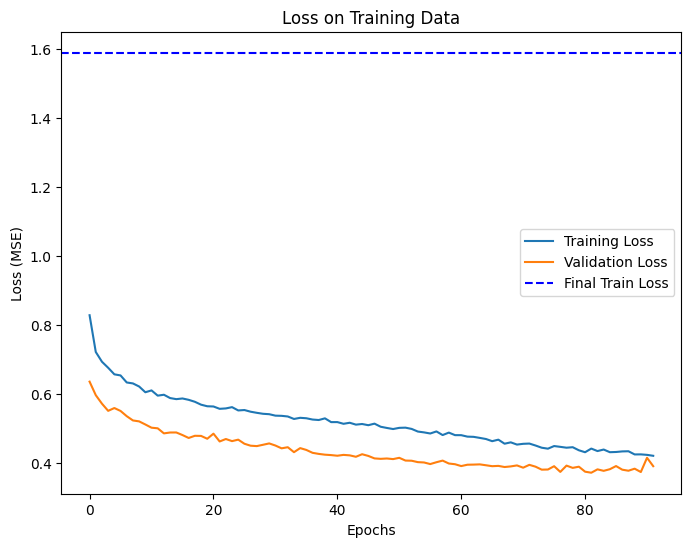

Final Training Loss (MSE): 1.5882420942009359
Final Training RMSE: 1.2602547735283274


In [196]:
train_predictions = model.predict(X_train_scaled)  # Use scaled X data
train_loss = np.mean((y_train_scaled - train_predictions.flatten())**2)  # Use scaled y data
train_rmse = np.sqrt(train_loss)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history .history['loss'], label='Training Loss')  # Training loss during epochs
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final Train Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")
print(f"Final Training RMSE: {train_rmse}")

In [197]:
# Prepare test data
X_test = df_test_data.drop(['No'], axis=1)
X_test_scaled = x_scaler.transform(X_test)
X_test_scaled = np.expand_dims(X_test_scaled, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model.predict(X_test_scaled)

# transform to correct scale
predictions = y_scaler.inverse_transform(predictions)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(df_test_data.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')
submission.to_csv('/content/subm_fix23.csv', index=False)
print("Submission file saved successfully!")
print(submission.head())

411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Submission file saved successfully!
                 row ID  pm2.5
6   2013-07-02 10:00:00     26
7   2013-07-02 11:00:00     21
8   2013-07-02 12:00:00     12
9   2013-07-02 13:00:00     10
10  2013-07-02 14:00:00      9
